# Imports and parameters

In [1]:
import os
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt

from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
#---------- Analysis
Nmc = 100
reset_mcmc = True

In [3]:
#---------- Data
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')+'Radio'

# Extracted from Gitti's paper
prof_file = dat_dir+'/Perseus_radio_profile_Gitti.txt' 
prof_data1 = pd.read_csv(prof_file, header=None, skiprows=1, index_col=False, names=['radius', 'flux', 'error_m', 'error_p'])
prof_data1['error_m'] = np.log(10)*10**prof_data1['flux'] * prof_data1['error_m'] / 2
prof_data1['error_p'] = np.log(10)*10**prof_data1['flux'] * prof_data1['error_p'] / 2
prof_data1['flux'] = 10**prof_data1['flux']

# Provided by G.F.B.
prof_data2 = {'radius':np.array([239.2,217.8,203.5,192.8,185.7,167.8,153.5,139.2,128.5,110.7,092.8,082.1,067.8,053.6,042.8,039.3,028.6,014.3]), 
             'flux_m':np.array([0.003667,0.003667,0.003643,0.007334,0.011000,0.018340,0.036670,0.036670,0.055010,0.073340,0.073340,0.183400,0.366700,0.550100,0.733400,0.733400,3.667000,14.66800]),
             'flux_p':np.array([0.036670,0.036670,0.018340,0.055010,0.055010,0.091680,0.183400,0.366700,0.366700,0.550100,0.550100,0.733400,0.733400,1.375100,3.667000,3.667000,7.334100,14.66800])}
prof_data2['flux'] = 0.5*(prof_data2['flux_m'] + prof_data2['flux_p'])
prof_data2['error_m'] =    (prof_data2['flux'] - prof_data2['flux_m'])
prof_data2['error_p'] =   -(prof_data2['flux'] - prof_data2['flux_p'])

prof_data = {'radius':prof_data2['radius'][::-1]*u.kpc,
             'flux':np.array(prof_data1['flux'])*u.Jy/u.arcmin**2,
             'error_p':(prof_data2['flux_p'][::-1] - np.array(prof_data1['flux']))*u.Jy/u.arcmin**2,
             'error_m':(np.array(prof_data1['flux'])   - prof_data2['flux_m'][::-1])*u.Jy/u.arcmin**2,
             'freq0':327*u.MHz}

spec_data = {'freq':np.array([327,609,1395])*u.MHz, 
             'flux':np.array([1.2423625254582,0.8798370672098,0.4765784114053]), # This is log F/Jy here
             'error':np.array([0.12219959266803,0.08961303462322,0.05702647657841])}
spec_data['error'] = np.log(10)*10**spec_data['flux'] * spec_data['error'] * u.Jy
spec_data['flux'] = 10**spec_data['flux'] *u.Jy

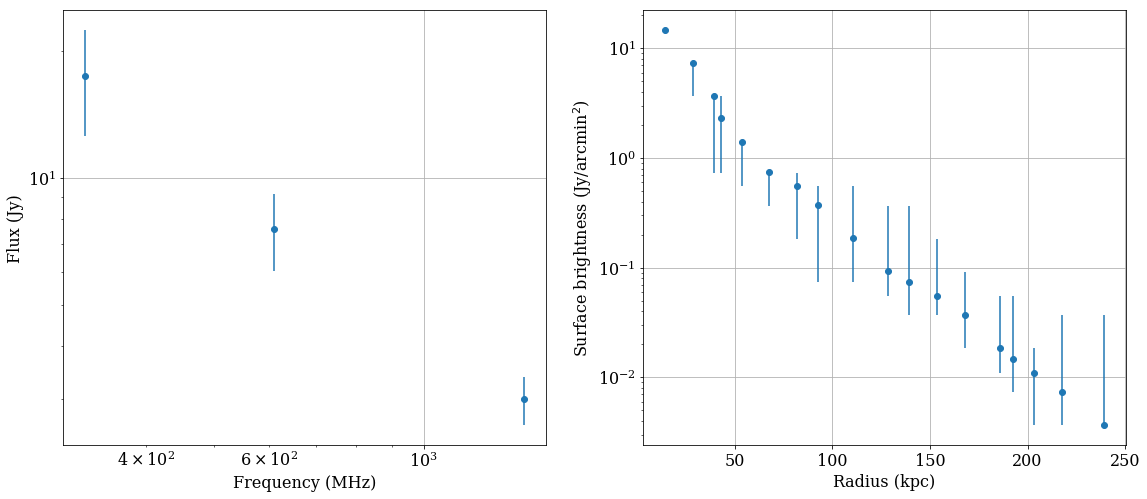

In [4]:
fig = plt.figure(0, figsize=(18, 8))
ax = plt.subplot(121)
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', linestyle='')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.grid()

ax = plt.subplot(122)
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=(prof_data['error_m'].to_value('Jy arcmin-2'), prof_data['error_p'].to_value('Jy arcmin-2')),
             marker='o', linestyle='')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.grid()

# Define the cluster model

In [5]:
cluster = minot.Cluster(name='Perseus', redshift=0.0179, M500=6.2e14*u.Msun, cosmology=cosmo, silent=True)
cluster.coord = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')
cluster.output_dir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Thermodynamics
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.8, 'r_c1':80*u.kpc, 'n_01':3.9e-2*u.cm**-3,
                             'beta2':0.87, 'r_c2':280*u.kpc, 'n_02':4.05e-3*u.cm**-3}
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':0.0026*u.keV/u.cm**3, 'r_p':1088*u.kpc,
                              'a':2.74, 'b':4.21, 'c':0.52}
# CR
cluster.set_density_cre1_isobaric_scal_param(scal=1.0)
cluster.X_cre1_E = {'X':0, 'R_norm':cluster.R500}
cluster.set_density_crp_isobaric_scal_param(scal=1.0)
cluster.X_crp_E = {'X':0.01, 'R_norm':cluster.R500}

# B field strenght
cluster.set_magfield_isodens_scal_param(Bnorm=1*u.uG, r0=10*u.kpc, scal=1)
eta, Bnorm, rnorm = 0.5, 25*u.uG, 10*u.kpc
r, B = cluster.get_magfield_profile(radius=np.logspace(-1,5,10000)*u.kpc)
r_ref, B_ref = cluster.get_magfield_profile(rnorm)
cluster.magfield_model = {'name':'User', 'radius':r, 'profile':Bnorm*(B/B_ref[0])**eta}

# Sampling
cluster.Npt_per_decade_integ = 10

# MCMC fit

In [6]:
#----- Defines log likelihood
def lnlike(params, cluster, data):
    cond1 = params[0]>=0 and params[1]>=0
    if cond1:
        mod = model(params, cluster, data)
        err = (0.5*(data['error_p'] + data['error_m'])).to_value('Jy arcmin-2')
        chi2 = ((data['flux'].to_value('Jy arcmin-2') - mod.to_value('Jy arcmin-2'))**2) / (err**2)
        return -0.5*np.nansum(chi2)
    else:
        return -np.inf

In [7]:
#----- Defines model
def model(params, cluster, data):
    X_crp_E  = params[0]
    scal_crp = params[1]
    
    cluster.set_density_crp_isobaric_scal_param(scal=scal_crp)
    cluster.X_crp_E = {'X':X_crp_E, 'R_norm':cluster.R500}
    
    r_synch, p_synch = cluster.get_synchrotron_profile(data['radius'], freq0=data['freq0'])
    
    return p_synch

In [8]:
#----- Define the MCMC
par0 = np.array([0.01, 
                 5.0])
    
param_name = ['X', 's']
ndim, nwalkers, nsteps, burnin = len(par0), 10, 1000, 100
pos = [par0 + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=[cluster, prof_data], 
                                a=2.0, threads=2)

In [9]:
#----- Restart from where it is or reset
if reset_mcmc:
    sampler.reset()
else:
    pos = sampler.chain[:,-1,:]

In [ ]:
#----- Run the MCMC
sampler.run_mcmc(pos, nsteps)

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [ ]:
#----- Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [ ]:
#----- Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
param_best = []
for i in range(ndim):
    param_best.append(((param_chains[:,:,i])[wbest])[0])

In [ ]:
#----- MC parameters
param_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2])
Nsample = len(param_flat[:,0])-1
param_MC = np.zeros((Nmc, ndim))
for i in range(Nmc):
    param_MC[i,:] = param_flat[np.random.randint(0, high=Nsample), :] # randomly taken from chains

# Result

### Parameters

In [ ]:
print(param_best)

In [ ]:
#----- Parameter space
par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
fig = corner.corner(par_flat, bins=50, color='k', smooth=1, labels=param_name, quantiles=(0.16, 0.84))

### Data versus best-fit

In [ ]:
best_fit = model(param_best, cluster, prof_data)

In [ ]:
fig = plt.figure(0, figsize=(18, 8))
ax = plt.subplot(121)
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', linestyle='')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.grid()

ax = plt.subplot(122)
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=(prof_data['error_m'].to_value('Jy arcmin-2'), prof_data['error_p'].to_value('Jy arcmin-2')),
             marker='o', linestyle='')
plt.plot(prof_data['radius'].to_value('kpc'), best_fit.to_value('Jy arcmin-2'))
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.grid()